# Anomly Detection Training tcnae

## Util Function

### Import Lib

In [1]:
# Import the libraries
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model,save_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input, ConvLSTM2D, Bidirectional,BatchNormalization
from tensorflow.keras import Input
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import math
import json
from IPython.core.pylabtools import figsize

figsize(15, 7) 

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Utils

In [2]:
def read_data(path,o_dtname="Datetime",c_dtname = 'datetime',names=None,skiprows=None):
    df = pd.read_csv(path, sep=',', 
                     parse_dates={c_dtname:[o_dtname]}, 
                     infer_datetime_format=True, 
                     low_memory=False, 
                     na_values=['nan','?'], 
                     index_col=c_dtname,
                     names=names,
                    skiprows=skiprows)

    #df = df.reindex(index=df.index[:,:-1])
    print(df.isnull().sum())
    # filling nan with mean in any columns
    #for j in range(df.shape[1]):        
        #df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
        
    #df.iloc[:,4:] = df.iloc[:,4:]*100
    #another sanity check to make sure that there are not more any nan
    #print(df.isnull().sum())
    #print(df.head())
    return df
#draw_trend
def draw_trend(df,groups,bound=200):
    #figsize(15,10) 
    
    anomly_df = df.copy()
    anomly_df[anomly_df>0] = np.nan
    
    i=1
    Values = df.values
    Anomaly = anomly_df.values
    cols = groups
    
    for group in groups:
        plt.subplot(len(cols), 1, i)
        plt.plot(Values[:bound, group],linewidth=3)
        plt.plot(Anomaly[:bound, group],color='red',linewidth=8)
        plt.title(df.columns[group], y=0.80, loc='right')
        #plt.xticks(range(0,4020,20))
        i += 1
    plt.show()
    print('\n')

def draw_trend_resample(df,groups,resample_freq,bound=200):
    #figsize(15,10) 
    i=1
    Values = df.resample(resample_freq).mean().values
    cols = groups
    for group in groups:
        plt.subplot(len(cols), 1, i)
        plt.plot(Values[:bound, group],linewidth=3)
        #plt.xticks(range(0,bound+10,10))
        plt.title(df.columns[group]+' resample-{}'.format(resample_freq), y=0.80, loc='right')
        i += 1
    plt.tight_layout()
    plt.show()
    
    print('\n')
#draw_corr
def show_corr(df,group):
    plt.matshow(df.iloc[:,group].corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    plt.title('Spearman_original', size=15)
    plt.xticks(range(len(group)),labels=map(str,group))
    plt.yticks(range(len(group)),labels=map(str,group))
    plt.colorbar()
    plt.show()
    
def show_corr_resample(df,group,resample_freq):
    plt.matshow(df.resample(resample_freq).mean().iloc[:,group].corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    plt.title('Spearman_resample-{}'.format(resample_freq), size=15)
    plt.xticks(range(len(group)),labels=map(str,group))
    plt.yticks(range(len(group)),labels=map(str,group))
    plt.colorbar()
    plt.show()
    

In [3]:
from scipy import stats
def gen_dataset(data,x_window_size,y_window_size):
    X_train = []   #預測點的前 60 天的資料
    y_train = []   #預測點
    for i in range(x_window_size, data.shape[0]-y_window_size,y_window_size):
        X_train.append(data.iloc[i-x_window_size:i, :-1].values)
        
        if np.sum(data.iloc[i-x_window_size:i, -1].values) >= 1:
            y_train.append(1)
        else:
            y_train.append(0)

    X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN
    
    #X_train = np.reshape(X_train, (X_train.shape[0], x_window_size,data.shape[1] ))

    """if y_window_size == 1:
        y_train = np.reshape(y_train,(y_train.shape[0], y_train.shape[2]))
    else:
        y_train = np.reshape(y_train,(y_train.shape[0],y_window_size,y_train.shape[2]))"""
        
    print("Gen data info:")
    print("X_data_shape:{}".format(X_train.shape))
    print("y_data_shape:{}".format(y_train.shape))
    print("\n")
          
    return X_train,y_train

def data_scaling(data,X_win_size,y_win_size,mode='robust'):
    
    assert mode == 'robust' or mode == 'minmax','Wrong mode name'
    print("Mode:{}\n".format(mode))
    print(data.describe())
    
    #Record training data index
    data_index = data.shape[0]
   
    # Feature Scaling
    from sklearn.preprocessing import MinMaxScaler,RobustScaler
    if mode =='robust':
         #RobustScaler
        scaler = RobustScaler()
        data[list(data.columns)[:-1]] = scaler.fit_transform(data[list(data.columns)[:-1]])     
    elif mode == 'minmax':        
        #MinMaxScaler
        scaler = MinMaxScaler()
        data.iloc[:,:-1] = scaler.fit_transform(data.iloc[:,:-1])     
    
    print(data.describe())
    #generate dataset
    data_X,data_y = gen_dataset(data,X_win_size,y_win_size)
    
    return data_X,data_y,scaler,data,scaler.get_params()


## Training Proccess

### Read Data

# Test df

## save test data

In [38]:
test_df.to_csv("test_df.csv")
np.save("X_test.npy",X_test)
np.save("y_test.npy",y_test)

NameError: name 'test_df' is not defined

### Save Scaler pickle

In [39]:
from pickle import dump

#dump(scaler, open('5v_scaler.pkl', 'wb'))
dump(scaler, open('6v_minmax_scaler.pkl', 'wb'))

## Random Search TCN_AE

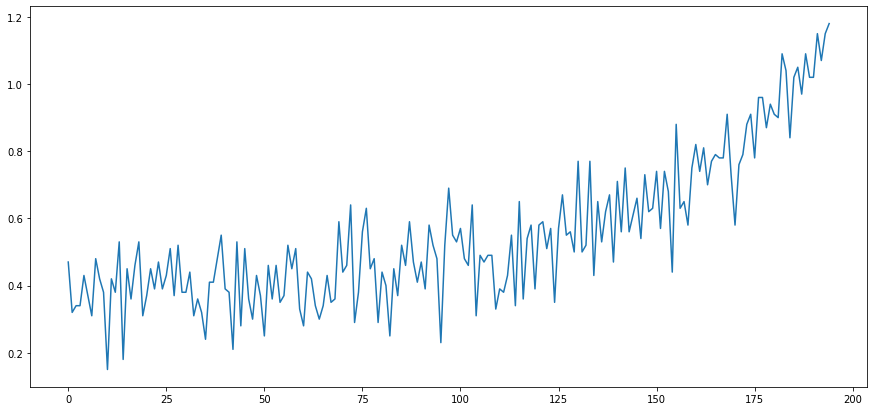

In [88]:
from sklearn.model_selection import train_test_split
import seaborn as sns

X_WIN = 16
Y_WIN = 1
SCALE_MODE = 'minmax'
select_col = ["CPU utilization (%)","Memory used  (%)","C_anomaly_label"]
def anomaly_map(x):
    label = 1 if x >0 else 0
    return label

#data["gender"] = data["gender"].map(gender_map)
df = pd.read_csv("./RUL_data/53.csv")
plt.plot(df["s11"]-47)



In [102]:
X.shape[0]

1

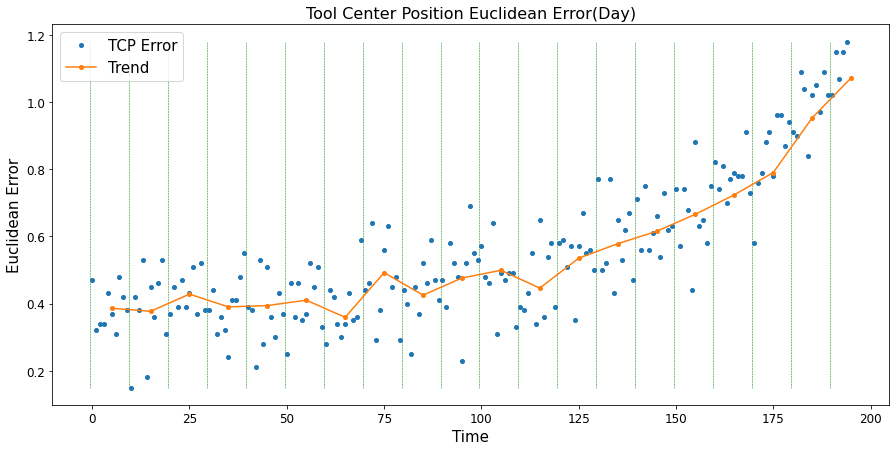

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.approximation import PiecewiseAggregateApproximation

X = df["s11"].values.reshape(1,-1)-47
window_size = 10
n_timestamps = X.shape[1]
paa = PiecewiseAggregateApproximation(window_size=window_size)
X_paa = paa.transform(X)

# Show the results for the first time series
plt.figure(figsize=(15,7))
plt.plot(X[0], 'o', ms=4, label='TCP Error')
plt.plot(np.arange(window_size // 2,
                   n_timestamps + window_size // 2,
                   window_size), X_paa[0], 'o-', ms=4, label='Trend')
plt.vlines(np.arange(0, n_timestamps, window_size) - 0.5,
           X[0].min(), X[0].max(), color='g', linestyles='--', linewidth=0.5)
plt.legend(loc='best', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Euclidean Error', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Tool Center Position Euclidean Error(Day)', fontsize=16)
plt.savefig("Tool Center Position Euclidean Error.jpg")
plt.show()


In [52]:
 from sklearn.preprocessing import MinMaxScaler
    

s11_arr = df['s11'].values.reshape(-1,1)
scaler = MinMaxScaler()
s11_arr = scaler.fit_transform(s11_arr)

def pre_proc(data,X_win_size,y_win_size):
    X_train = []
    y_train = []
    for i in range(X_win_size, data.shape[0]-y_win_size,y_win_size):
            X_train.append(data[i-X_win_size:i, :])
            y_train.append(data[i:i+y_win_size, :])
    
    return np.array(X_train),np.array(y_train)

X_train,y_train = pre_proc(s11_arr,16,1)
print(y_train.shape)

(178, 1, 1)


Epoch 1/100
5/5 - 4s - loss: 157.4887 - val_loss: 26.2471 - 4s/epoch - 785ms/step
Epoch 2/100
5/5 - 0s - loss: 7.7059 - val_loss: 0.9201 - 192ms/epoch - 38ms/step
Epoch 3/100
5/5 - 0s - loss: 7.7188 - val_loss: 0.3005 - 178ms/epoch - 36ms/step
Epoch 4/100
5/5 - 0s - loss: 5.8561 - val_loss: 6.6782 - 150ms/epoch - 30ms/step
Epoch 5/100
5/5 - 0s - loss: 2.0245 - val_loss: 4.8993 - 151ms/epoch - 30ms/step
Epoch 6/100
5/5 - 0s - loss: 0.6072 - val_loss: 2.8781 - 158ms/epoch - 32ms/step
Epoch 7/100
5/5 - 0s - loss: 0.2618 - val_loss: 0.0934 - 148ms/epoch - 30ms/step
Epoch 8/100
5/5 - 0s - loss: 0.3488 - val_loss: 0.2674 - 147ms/epoch - 29ms/step
Epoch 9/100
5/5 - 0s - loss: 0.2015 - val_loss: 0.8406 - 134ms/epoch - 27ms/step
Epoch 10/100
5/5 - 0s - loss: 0.0743 - val_loss: 0.0959 - 130ms/epoch - 26ms/step
Epoch 11/100
5/5 - 0s - loss: 0.0787 - val_loss: 0.0296 - 122ms/epoch - 24ms/step
Epoch 12/100
5/5 - 0s - loss: 0.0700 - val_loss: 0.1243 - 153ms/epoch - 31ms/step
Epoch 13/100
5/5 - 0s - 

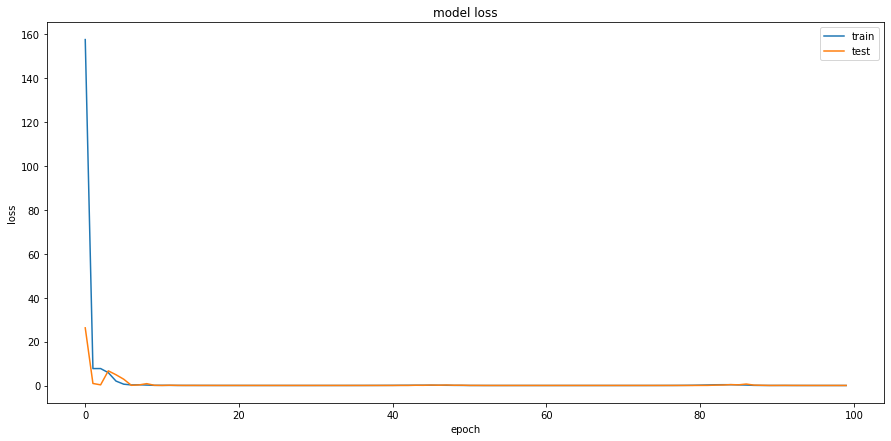

In [54]:
from sklearn.utils import shuffle
from sklearn.model_selection import ParameterSampler
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import traceback,datetime
import numpy as np
import pandas as pd
import os
import importlib
from IPython.display import clear_output
import seaborn as sns
from tcn import TCN, tcn_full_summary

model = Sequential()
model.add(TCN(
            input_shape=(X_train.shape[1], X_train.shape[2]),
            nb_filters=64,
            kernel_size=3,
            nb_stacks=3,
            dilations=[1,2,4,8],
            use_skip_connections=True,
            dropout_rate=0.0,
            use_batch_norm=False,
            use_layer_norm=False,
        ))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=2, shuffle=False)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()



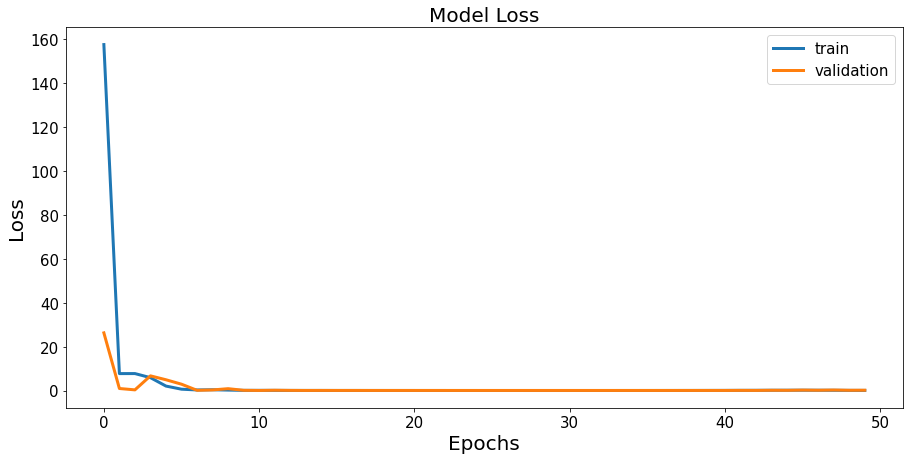

In [195]:
plt.plot(history.history['loss'][:50],linewidth=3)
plt.plot(history.history['val_loss'][:50],linewidth=3)
plt.title('Model Loss',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['train', 'validation'], loc='upper right',fontsize=15)
plt.savefig("Training history.jpg")
plt.show()

In [209]:
df["s11"][16:].values.shape


(178, 1)

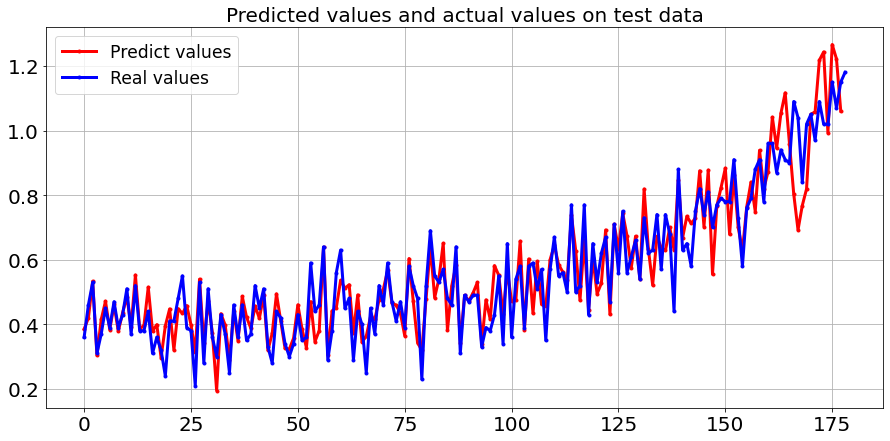

Model,MAE,RMSE,MAPE
TCN,0.119,0.141,0.487,0.571


In [216]:
# make a prediction
yhat = model.predict(X_train)

inv_yhat = scaler.inverse_transform(yhat.reshape(-1,1))

plt.plot(inv_yhat-47,color = 'red',marker='.', label = 'Predict values',linewidth=3)
plt.plot(df["s11"][16:].values-47,color = 'blue',marker='.', label = 'Real values',linewidth=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize='xx-large')
plt.title('Predicted values and actual values on test data',fontsize=20)
plt.savefig("Predicted values.jpg")
plt.show()



def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def cal_score(y_real,y_hat,model_name):
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error,r2_score
    import math

    MAEScore = mean_absolute_error(y_real,y_hat)
    RMSEScore = math.sqrt(mean_squared_error(y_real,y_hat))
    MAPEScore = mean_absolute_percentage_error(y_real,y_hat)
    R2_Score = r2_score(y_real,y_hat)
        
    print("Model,MAE,RMSE,MAPE")
    print("{},{},{},{},{}".format(model_name,round(MAEScore,3),round(RMSEScore,3),round(MAPEScore,3),round(R2_Score,3)))
    
    
    return round(MAEScore,3),round(RMSEScore,3),round(MAPEScore,3)


MAE,RMSE,MAPE = cal_score(df["s11"][17:].values,inv_yhat,"TCN")


In [72]:
real_arr = df["s11"].values
real_arr.shape

(195,)

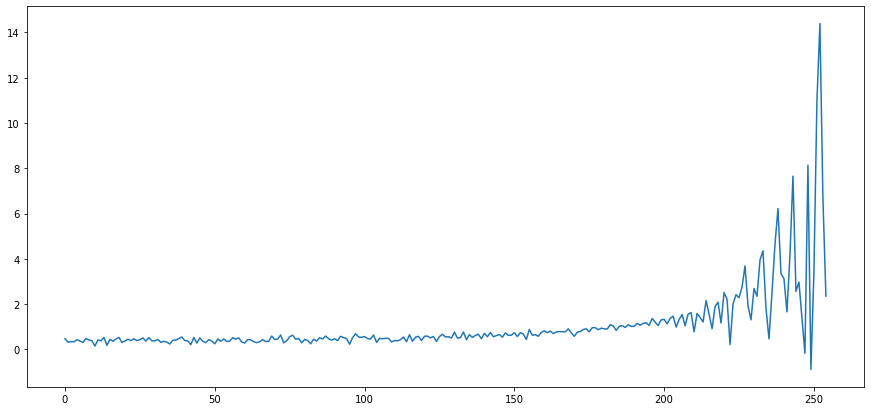

In [131]:
tmp = X_train[-1]
real_arr = df["s11"].values
for i in range(60):
    yhat = model.predict(tmp.reshape(1,16,1))
    inv_yhat = scaler.inverse_transform(yhat.reshape(-1,1))
    #print(inv_yhat)
    res = np.concatenate([tmp[1:,:],yhat.reshape(1,1)],axis=0)
    
    tmp = res
    real_arr = np.concatenate([real_arr,inv_yhat.reshape(1,)],axis=0)

np.savetxt("predict_350.csv", real_arr-47, delimiter=",")
plt.plot(real_arr-47)
plt.show()

In [218]:
df["s11"].values.shape

(195,)

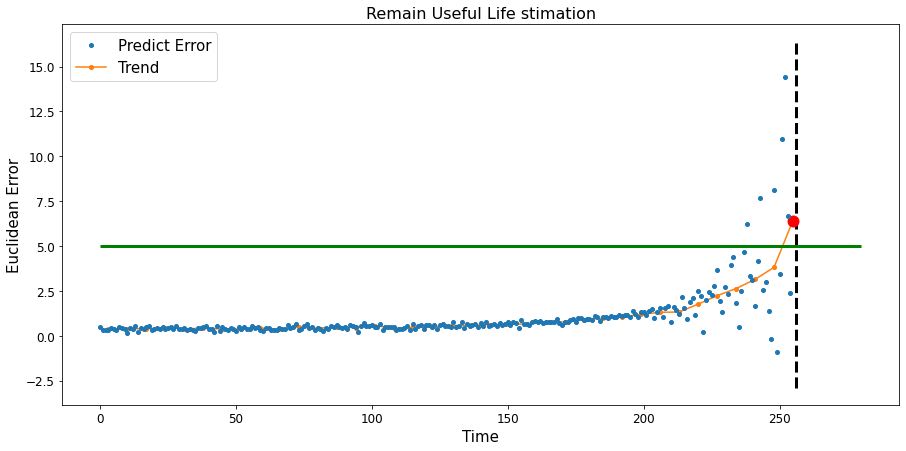

In [178]:
X = real_arr.reshape(1,-1)-47

window_size = 7
n_timestamps = X.shape[1]
paa = PiecewiseAggregateApproximation(window_size=window_size)
X_paa = paa.transform(X)

# Show the results for the first time series
plt.figure(figsize=(15,7))
plt.plot(X[0], 'o', ms=4, label='Predict Error')
plt.plot(np.arange(window_size // 2,
                   n_timestamps + window_size // 2,
                   window_size), X_paa[0], 'o-', ms=4, label='Trend',zorder=1)
plt.vlines(256,
           X[0].min()-2, X[0].max()+2, color='black', linestyles='--', linewidth=3)
plt.hlines(5,
           0, 280, color='g', linestyles='-', linewidth=3)
plt.scatter(x=255,y=6.4,color="red",zorder=2,s=120)
plt.legend(loc='best', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Euclidean Error', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Remain Useful Life stimation', fontsize=16)
plt.savefig("RUL estimation.jpg")
plt.show()


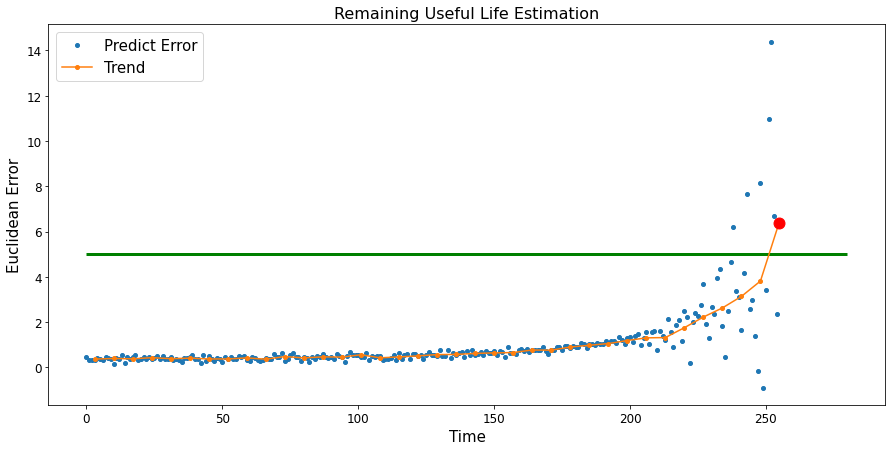

In [182]:
#Method part

X = real_arr.reshape(1,-1)-47

window_size = 7
n_timestamps = X.shape[1]
paa = PiecewiseAggregateApproximation(window_size=window_size)
X_paa = paa.transform(X)

# Show the results for the first time series
plt.figure(figsize=(15,7))
plt.plot(X[0], 'o', ms=4, label='Predict Error',zorder=1)
plt.plot(np.arange(window_size // 2,
                   n_timestamps + window_size // 2,
                   window_size), X_paa[0], 'o-', ms=4, label='Trend',zorder=2)

plt.hlines(5,
           0, 280, color='g', linestyles='-', linewidth=3)
plt.scatter(x=255,y=6.4,color="red",zorder=3,s=120)
plt.legend(loc='best', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Euclidean Error', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Remaining Useful Life Estimation', fontsize=16)
plt.savefig("RUL estimation sample img.jpg")
plt.show()


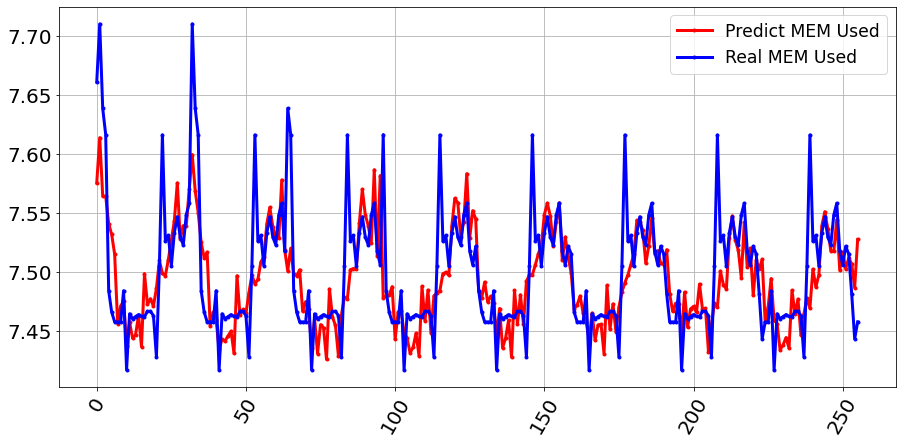

In [ ]:
plt.plot(yhat[:,0].flatten()[:256],color = 'red',marker='.', label = 'Predict MEM Used',linewidth=3)
plt.plot(x[:,0].flatten()[:256],color = 'blue',marker='.', label = 'Real MEM Used',linewidth=3)
plt.xticks(fontsize=20,rotation=60)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize='xx-large')
#plt.title('Predicted values and actual values on test data',fontsize=20)
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def cal_score(y_real,y_hat,model_name):
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    import math

    MAEScore = mean_absolute_error(y_real,y_hat)
    RMSEScore = math.sqrt(mean_squared_error(y_real,y_hat))
    MAPEScore = mean_absolute_percentage_error(y_real,y_hat)
        
    print("Model,MAE,RMSE,MAPE")
    print("{},{},{},{}".format(model_name,round(MAEScore,3),round(RMSEScore,3),round(MAPEScore,3)))
    
    
    return round(MAEScore,3),round(RMSEScore,3),round(MAPEScore,3)

MAE,RMSE,MAPE = cal_score(x,x_hat,"Conv")
MAE,RMSE,MAPE = cal_score(x,x_hat,"TCN")

Conv
MAE:0.15
RMSE:0.527
MAPE:4.775
